In [147]:
import pandas as pd

df = pd.read_csv("final_imputed_dataset1.csv")

In [148]:
df.isnull().sum()

Unnamed: 0       0
GVKEY            0
datadate         0
fyear            0
indfmt           0
consol           0
popsrc           0
datafmt          0
conm             0
curcd            0
aco              0
act              0
aqc              0
at               0
capx             0
ceq              0
ebit             0
icapt            0
lct              0
ni               0
revt             0
seq              0
xrd           2322
xrdp          2339
costat           0
sic              0
dtype: int64

In [149]:
# Calculate y = capx/at
df['y'] = df['capx'] / df['at']

# Calculate liquidity = act/lct
df['liquidity'] = df['act'] / df['lct']

# Calculate leverage = lct/ceq
df['leverage'] = df['lct'] / df['ceq']

# Assign size = at
df['size'] = df['at']

# Calculate roa = ni/at
df['roa'] = df['ni'] / df['at']

df['prev_inv'] = df['y'].shift(-1)

df['prev_year_at'] = df['at'].shift(1)

# Calculate the growth rate
df['asset_growth'] = df['at'] / df['prev_year_at']

# Drop the 'prev_year_at' column if not needed anymore
df.drop(columns=['prev_year_at'], inplace=True)


In [150]:
df.isnull().sum()

Unnamed: 0         0
GVKEY              0
datadate           0
fyear              0
indfmt             0
consol             0
popsrc             0
datafmt            0
conm               0
curcd              0
aco                0
act                0
aqc                0
at                 0
capx               0
ceq                0
ebit               0
icapt              0
lct                0
ni                 0
revt               0
seq                0
xrd             2322
xrdp            2339
costat             0
sic                0
y                  0
liquidity          0
leverage           0
size               0
roa                0
prev_inv           1
asset_growth       1
dtype: int64

In [151]:
df = df[(df['fyear'] >= 2000) & (df['fyear'] <= 2021)]

In [152]:
df.isnull().sum()

Unnamed: 0         0
GVKEY              0
datadate           0
fyear              0
indfmt             0
consol             0
popsrc             0
datafmt            0
conm               0
curcd              0
aco                0
act                0
aqc                0
at                 0
capx               0
ceq                0
ebit               0
icapt              0
lct                0
ni                 0
revt               0
seq                0
xrd             2128
xrdp            2141
costat             0
sic                0
y                  0
liquidity          0
leverage           0
size               0
roa                0
prev_inv           0
asset_growth       0
dtype: int64

In [153]:
# adding cpu 
# Assuming df_cpu1 is your DataFrame containing the dataset
df_cpu1 = pd.read_csv('CPU index.csv')
# Convert 'date' column to datetime format with custom date parser
df_cpu1['date'] = pd.to_datetime(df_cpu1['date'], format='%b-%y')

# Extract year from 'date' column
df_cpu1['year'] = df_cpu1['date'].dt.year

# Drop the 'old_cpu_index' column
df_cpu1.drop(columns='old_cpu_index', inplace=True)

# Group by year and compute average cpu_index
average_cpu_index = df_cpu1.groupby('year')['cpu_index'].mean().reset_index()

# Verify the result
print(average_cpu_index)

    year   cpu_index
0   1987   59.666897
1   1988   65.722413
2   1989   76.697151
3   1990   94.779705
4   1991   80.746618
5   1992   88.297105
6   1993   78.883753
7   1994   70.176454
8   1995   83.972636
9   1996   66.936481
10  1997   60.388895
11  1998   57.564906
12  1999   58.748100
13  2000   62.448747
14  2001   93.647460
15  2002   88.280674
16  2003   67.846581
17  2004   65.208485
18  2005   66.038375
19  2006   67.521463
20  2007  107.765643
21  2008   97.135520
22  2009   99.128977
23  2010  112.572259
24  2011  114.578606
25  2012  100.094996
26  2013   77.565805
27  2014   83.167437
28  2015   92.614515
29  2016  120.715749
30  2017  169.765549
31  2018  143.290591
32  2019  192.001778
33  2020  218.634176
34  2021  215.384017
35  2022  225.413245
36  2023  221.172666


In [154]:
combined_data = pd.merge(df, average_cpu_index, left_on='fyear', right_on='year', how='inner')

In [155]:
combined_data.shape

(6072, 35)

In [156]:
combined_data["GVKEY"].value_counts()

GVKEY
1075      22
12540     22
14225     22
13824     22
13714     22
          ..
6730      22
6733      22
6774      22
6829      22
126721    22
Name: count, Length: 276, dtype: int64

In [157]:
X = combined_data[['liquidity', 'leverage', 'roa', 'icapt', 'aqc', 'prev_inv', 'cpu_index', 'asset_growth']]
y = combined_data['y']

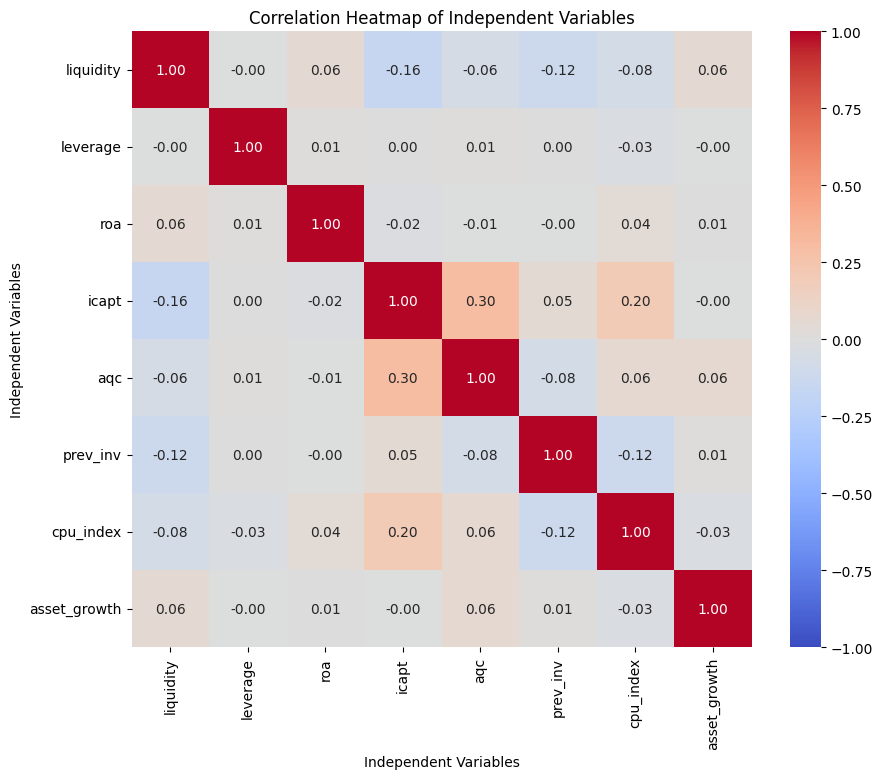

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = X.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Independent Variables')
plt.xlabel('Independent Variables')
plt.ylabel('Independent Variables')
plt.show()


In [159]:
import numpy as np
X = X.applymap(lambda x: np.log(x) if x > 0 else x)
y = np.log(combined_data['y'])

In [160]:
X

,liquidity,leverage,roa,icapt,aqc,prev_inv,cpu_index,asset_growth
0,-0.405825,-0.693197,-3.163223,8.375122,0.000000,-2.037374,4.134346,0.078636
1,0.540221,-0.690331,-1.702159,9.174431,0.000000,-2.819547,4.134346,0.054608
2,0.775244,-0.952044,-1.769399,8.375547,0.000000,-2.118500,4.134346,0.275756
3,0.272252,-0.718890,-4.198557,8.622022,5.138149,-2.434787,4.134346,0.004241
4,0.390569,-0.296824,-2.719636,9.521348,7.833204,-3.319816,4.134346,0.067703
...,...,...,...,...,...,...,...,...
6067,0.744100,0.010947,-3.010261,9.646787,0.000000,-4.232885,5.372423,0.077684
6068,0.146515,-0.528350,-2.713803,8.008675,6.019369,-5.055720,5.372423,0.066040
6069,0.454632,-0.833129,-3.560142,8.723540,5.261135,-4.485724,5.372423,-0.053809
6070,0.887842,-1.746016,-2.524887,8.883677,6.394969,-2.896892,5.372423,0.047113


In [161]:
X.isnull().sum()

liquidity       0
leverage        0
roa             0
icapt           0
aqc             0
prev_inv        0
cpu_index       0
asset_growth    0
dtype: int64

In [162]:
X.shape

(6072, 8)

In [163]:
X.isnull().sum()

liquidity       0
leverage        0
roa             0
icapt           0
aqc             0
prev_inv        0
cpu_index       0
asset_growth    0
dtype: int64

In [164]:
import statsmodels.api as sm

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     3376.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:12:41   Log-Likelihood:                -2173.6
No. Observations:                6072   AIC:                             4365.
Df Residuals:                    6063   BIC:                             4426.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0522      0.059      0.889   

**t-values**:
   - t-values represent the ratio of the estimated coefficient to its standard error.
   - They indicate the significance of the estimated coefficient.
   - Larger absolute t-values (in either direction) suggest greater evidence against the null hypothesis that the coefficient is zero.
   
**P-values (P>|t|)**:
   - P-values represent the probability of observing the estimated coefficient (or more extreme) if the null hypothesis (that the coefficient is zero) is true.
   - Small p-values (typically less than a chosen significance level, such as 0.05) suggest that the coefficient is statistically significant.
   - In this output, all p-values are very close to zero (0.000), indicating that all coefficients are statistically significant at conventional significance levels (e.g., 0.05).
   
**Confidence Intervals ([0.025 0.975])**:
   - Confidence intervals provide a range of plausible values for the true population parameter (the coefficient) based on the sample data.
   - They are typically constructed around the estimated coefficient and provide a sense of the precision of the estimate.
   - The confidence interval is calculated as the estimated coefficient plus or minus a margin of error.
   - In this output, the confidence intervals indicate the range within which we are reasonably confident the true coefficients lie.

**R-squared (or Adjusted R-squared) Test:**
R-squared measures the proportion of variance in the dependent variable that is explained by the independent variables in the model.
Adjusted R-squared adjusts for the number of independent variables in the model, providing a more conservative measure of model fit.
Both R-squared and Adjusted R-squared range from 0 to 1, with higher values indicating better fit.

In [165]:
# Calculate R-squared
r_squared = model.rsquared
print("R-squared:", r_squared)

# Calculate Adjusted R-squared
adjusted_r_squared = model.rsquared_adj
print("Adjusted R-squared:", adjusted_r_squared)


R-squared: 0.8166469540631469
Adjusted R-squared: 0.8164050236050412


The F-test assesses the overall significance of the model by comparing the explained variance to the unexplained variance.
A significant F-test indicates that at least one independent variable has a nonzero coefficient, suggesting that the model as a whole is significant.

In [166]:
# Get F-statistic and associated p-value
f_statistic = model.fvalue
p_value = model.f_pvalue

print("F-statistic:", f_statistic)
print("p-value:", p_value)


F-statistic: 3375.544197524608
p-value: 0.0
